In [2]:
# Common imports
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
from numpy.random import seed
from keras.layers import Input, Dropout
from keras.layers import Dense
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

In [3]:
merged_data = pd.read_csv('2nd_test_resmaple_10minutes.csv',index_col='Datetime',usecols=['Datetime','Bearing 1','Bearing 2','Bearing 3','Bearing 4'])
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
print(merged_data.head())

                     Bearing 1  Bearing 2  Bearing 3  Bearing 4
Datetime                                                       
2004-02-12 10:32:39   0.058333   0.071832   0.083242   0.043067
2004-02-12 10:42:39   0.058995   0.074006   0.084435   0.044541
2004-02-12 10:52:39   0.060236   0.074227   0.083926   0.044443
2004-02-12 11:02:39   0.061455   0.073844   0.084457   0.045081
2004-02-12 11:12:39   0.061361   0.075609   0.082837   0.045118


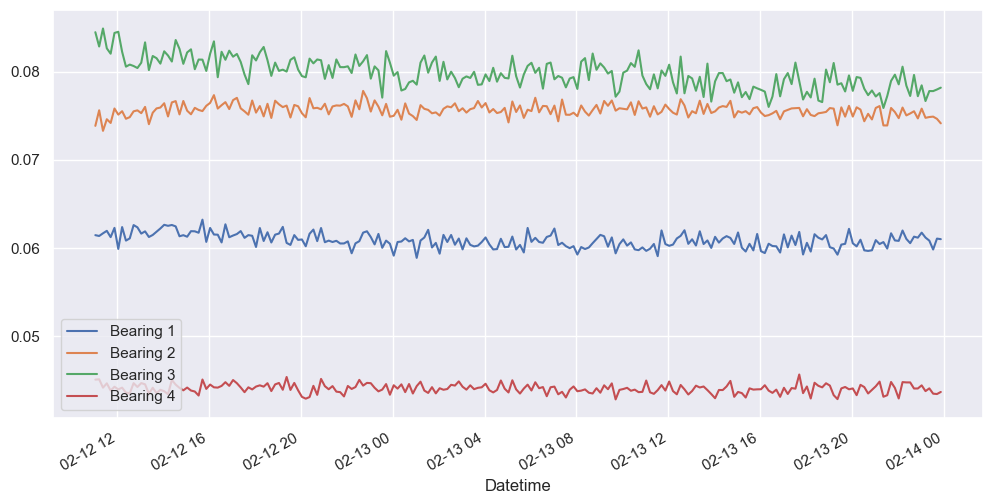

In [4]:
dataset_train = merged_data['2004-02-12 11:02:39':'2004-02-13 23:52:39']
dataset_test = merged_data['2004-02-13 23:52:39':]
dataset_train.plot(figsize = (12,6))
plt.show()

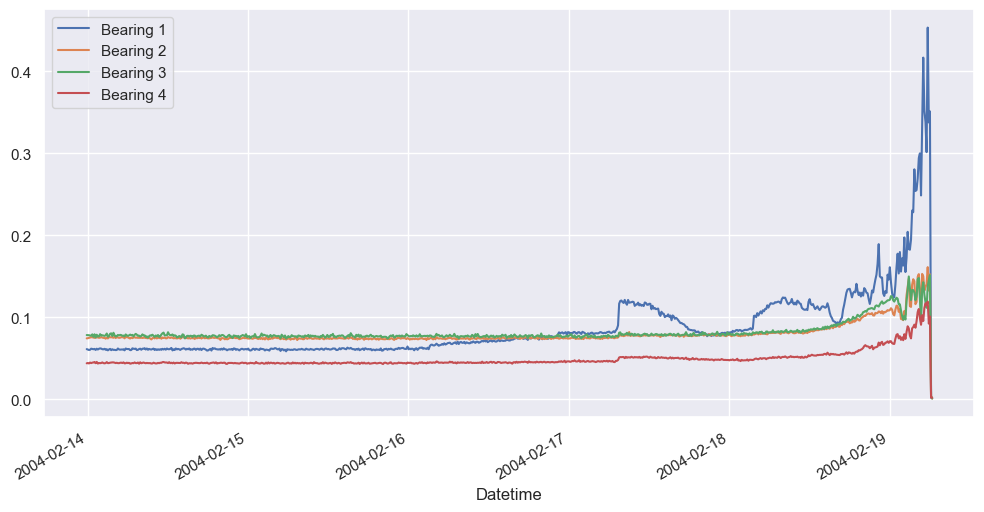

In [5]:
dataset_test.plot(figsize = (12,6))
plt.show()


In [6]:
"""
Normalize data
"""
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train),
                              columns=dataset_train.columns,
                              index=dataset_train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test),
                             columns=dataset_test.columns,
                             index=dataset_test.index)

In [7]:
import tensorflow as tf
tf.random.set_seed(10)
act_func = 'relu'

In [8]:
# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X.
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )
model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))
model.compile(loss='mse',optimizer='adam')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
 dense_2 (Dense)             (None, 10)                30        
                                                                 
 dense_3 (Dense)             (None, 4)                 44        
                                                                 
Total params: 146 (584.00 Byte)
Trainable params: 146 (584.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Epoch 1/100
21/21 [==============================] - 1s 8ms/step - loss: 0.2421 - val_loss: 0.1638
Epoch 2/100
21/21 [==============================] - 0s 2ms/step - loss: 0.2231 - val_loss: 0.1485
Epoch 3/100
21/21 [==============================] - 0s 2ms/step - loss: 0.2045 - val_loss: 0.1336
Epoch 4/100
21/21 [==============================] - 0s 2ms/step - loss: 0.1863 - val_loss: 0.1192
Epoch 5/100
21/21 [==============================] - 0s 2ms/step - loss: 0.1686 - val_loss: 0.1056
Epoch 6/100
21/21 [==============================] - 0s 2ms/step - loss: 0.1515 - val_loss: 0.0931
Epoch 7/100
21/21 [==============================] - 0s 2ms/step - loss: 0.1354 - val_loss: 0.0819
Epoch 8/100
21/21 [==============================] - 0s 2ms/step - loss: 0.1206 - val_loss: 0.0720
Epoch 9/100
21/21 [==============================] - 0s 2ms/step - loss: 0.1074 - val_loss: 0.0635
Epoch 10/100
21/21 [==============================] - 0s 2ms/step - loss: 0.0955 - val_loss: 0.0565
Epoch 11/

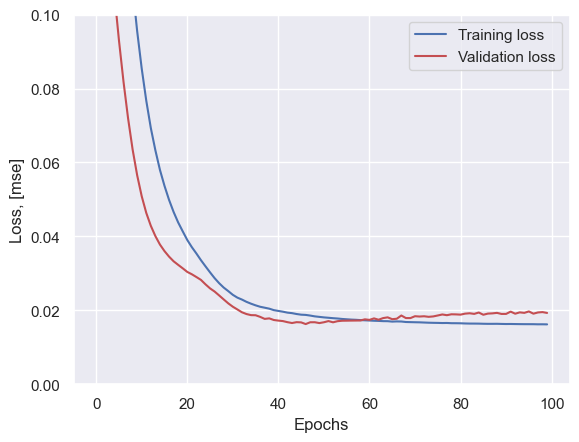

<Figure size 1200x600 with 0 Axes>

In [9]:
# Train model for 100 epochs, batch size of 10:
NUM_EPOCHS=100
BATCH_SIZE=10

history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE,
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.1])
plt.figure(figsize=(12,6))
plt.show()

7/7 [==============================] - 0s 1ms/step


C:\Users\11516\AppData\Local\Temp\ipykernel_11232\4166716787.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'],


(0.0, 0.5)

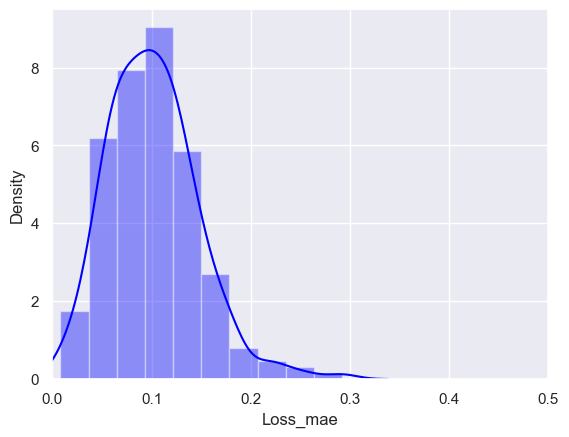

In [10]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred,
                      columns=X_train.columns)
X_pred.index = X_train.index
scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 10,
             kde= True,
            color = 'blue')
plt.xlim([0.0,.5])

In [11]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred,
                      columns=X_test.columns)
X_pred.index = X_test.index

print(X_pred.head())

threshod = 0.3
scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = threshod
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
print(scored.head())

24/24 [==============================] - 0s 668us/step
                     Bearing 1  Bearing 2  Bearing 3  Bearing 4
Datetime                                                       
2004-02-13 23:52:39   0.322250   0.459395   0.293126   0.335200
2004-02-14 00:02:39   0.314491   0.454038   0.282955   0.329180
2004-02-14 00:12:39   0.249704   0.410776   0.201680   0.266660
2004-02-14 00:22:39   0.345089   0.475163   0.323064   0.352919
2004-02-14 00:32:39   0.383444   0.501644   0.373342   0.382675
                     Loss_mae  Threshold  Anomaly
Datetime                                         
2004-02-13 23:52:39  0.128320        0.3    False
2004-02-14 00:02:39  0.100260        0.3    False
2004-02-14 00:12:39  0.035638        0.3    False
2004-02-14 00:22:39  0.130958        0.3    False
2004-02-14 00:32:39  0.110443        0.3    False


7/7 [==============================] - 0s 947us/step


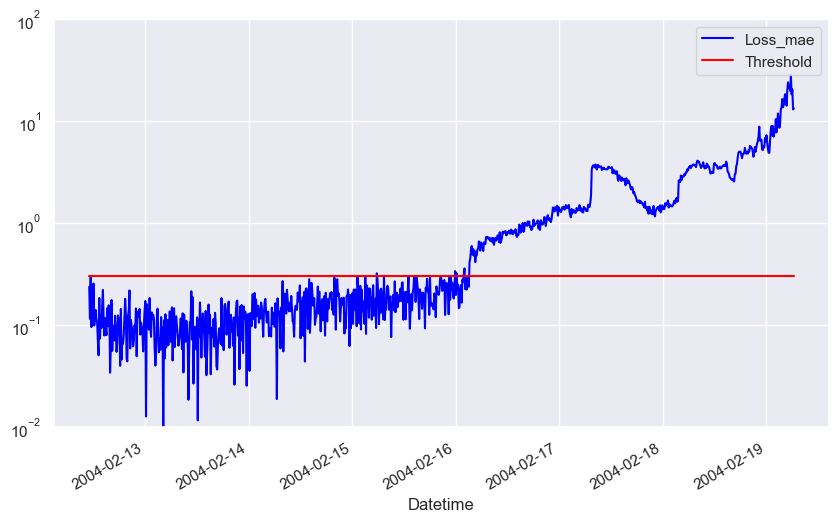

In [12]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train,
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = threshod
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])
plt.show()